In this notebook, we'll learn how to use a type of factorization called a **Singular Value Decomposition (SVD)** to compress an image!

Before we get started, let's review what SVDs are. To note, I'm targeting this material at someone who has already learned about SVDs but hasn't seen them in a while. If that's not you, that's okay! Hopefully you'll still enjoy the material. Just remember that if you're seeing this for the first time and it feels fast, that's because it is (so no reason to be frustrated!). :)

First off, *SVDs are generalizations of **eigendecompositions***. In physics and engineering, eigendecompositions are often more common than SVDs. Let's start by talking about eigendecompositions since you may have seen them more recently.

### Eigendecompositions

When we perform an eigendecomposition, we determine the eigenvalues and eigenvectors of a matrix $A_{sym}$ such that

$$A_{sym} = VΛV^T$$

when $V$ is the matrix that stores those eigenvectors as columns and $Λ$ is a diagonal matrix where the eigenvalues populate the diagonal.

As we saw in the last notebook, we can perform an eigendecomposition on a matrix `Asym` with the function `eigfact`:

In [1]:
A = rand(2, 2)

2×2 Array{Float64,2}:
 0.110136  0.12192 
 0.349209  0.864153

In [2]:
Asym = A + A'

2×2 Array{Float64,2}:
 0.220273  0.471129
 0.471129  1.72831 

In [3]:
eigAsym = eigfact(Asym)

Base.LinAlg.Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}([0.0851863, 1.86339], [-0.961266 0.275622; 0.275622 0.961266])

We can then grab the eigenvalues and eigenvectors with the `:values` and `:vectors` symbols:

In [4]:
V = eigAsym[:vectors]
eigvals = eigAsym[:values]

2-element Array{Float64,1}:
 0.0851863
 1.86339  

As a sanity check, let's check that we can reconstruct the original matrix, $A_{sym}$ from its eigendecomposition. First, we can build a diagonal matrix from the eigenvalues with the `Diagonal` function.

In [5]:
Λ = Diagonal(eigvals)

2×2 Diagonal{Float64}:
 0.0851863   ⋅     
  ⋅         1.86339

Does the matrix product $VΛV^T$ look like the original matrix, $A_{sym}$?

In [6]:
reconstructedAsym = V*Λ*V'

2×2 Array{Float64,2}:
 0.220273  0.471129
 0.471129  1.72831 

Things should be working as we might hope. So what is the importance of the eigenvectors and eigenvalues of a matrix anyways?


What's special about the eigenvectors of a matrix is that applying the matrix to them causes them to be stationary in space. In contrast, you can think of most vectors as "changing direction" or rotating through space when a matrix is applied to them.

*For example*, take the matrix $M$ that flips vectors across the $y$-axis:

In [7]:
M = [[-1, 0] [0, 1]]

2×2 Array{Int64,2}:
 -1  0
  0  1

When we apply $M$ to a vector $v$ where $v = [ v_1, v_2]$, we get $Mv = [-v_1, v_2]$. Let's see how this "flips" a vector across the $y$-axis:

In [8]:
# Load the colors package
using Colors
# Load the plots package and call a backend
using Plots
gr()

Plots.GRBackend()

In [9]:
"""
plot_2D_vector(v, M)

Given a 2D vector, v, and a matrix, M, plot v and M * v on an existing figure
in the same color. Plot v as an overlay of a line and points, and M*v as just a series of points."""
function plot_2D_vector(v, M)
    # choose a color to plot 
    c = rand(distinguishable_colors(15))
    # Define a function f(x) such that the point (x, f(x))
    # lies on the vector v
    f(x) = v[2]/v[1] * x
    # Plot vector v as a line
    plot!(f, color = c)
    scatter!(f, color = c)

    # Similarly, (x, g(x)) lies on the vector M*v
    g(x) = (M*v)[2]/(M*v)[1] * x
    # Plot M*v as a series of scatter points
    scatter!(g, color = c)
end

plot_2D_vector

In [10]:
# Now let's generate a plot
fig = plot(legend=false)
xlims!(-2, 2)
ylims!(-2, 2);

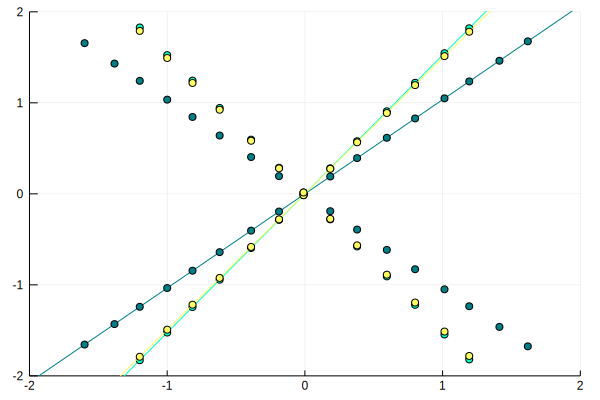

In [11]:
# And now add a few random vectors and their reflections to it
num_vectors = 3
for i in 1:num_vectors
    v_i = rand(2)
    plot_2D_vector(v_i, M)
end
fig

Above, each vector `v_i` is plotted in the same color as the vector `M*v_i` where `v_i` is plotted as a series of dots overlaid with a line and `M*v_i` is plotted as just a series of dots.

From the above, we can see that applying `M` to a vector causes it to be flipped across the vertical line centered at `0`.

What are the eigenvectors of `M` and what happens to them when we apply `M` to them?

Let's perform an eigendecomposition on `M`,

In [12]:
Meig = eigfact(M)

Base.LinAlg.Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}([-1.0, 1.0], [-1.0 0.0; 0.0 1.0])

grab the first eigenvector of `M`,

In [13]:
eigvec1 = Meig[:vectors][:, 1]

2-element Array{Float64,1}:
 -1.0
  0.0

and plot!

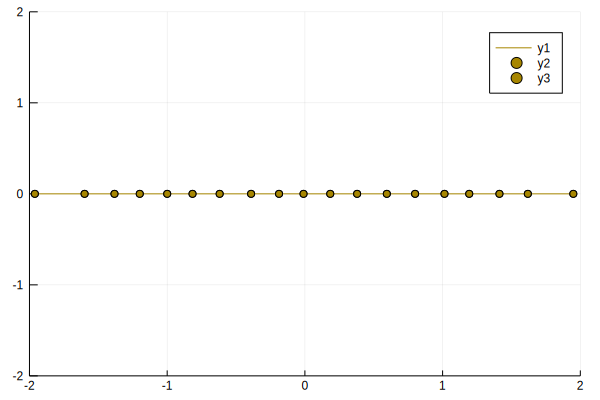

In [14]:
eigfig = plot()
xlims!(-2, 2)
ylims!(-2, 2)
plot_2D_vector(eigvec1, M)

Here we see only one vector plotted! `M*eigvec1` overlays perfectly with `eigvec1` because `eigvec1` is symmetric across the plane that `M` flips vectors!

**We can think of the eigenvectors of a matrix as carrying information about that matrix.** 

**The eigenvectors corresponding to the largest eigenvalues carry the most important information!**

### Singular Value Decompositions

There are times where an eigendecomposition or something *like* an eigendecomposition may be useful to us, but where an eigendecomposition is not possible. For example, we can't take the eigendecomposition of a nonsquare matrix, $A$. However, we **can** take the SVD of $A$!

We can perform a SVD on matrix A by finding unitary matrices $U$ and $V$ and singular values stored on the diagonal of matrix $S$ such that

$$A = USV^T$$

We can think of these singular values stored in $S$ as analogs to the eigenvalues that we get from an eigendecomposition.

Note that unitary matrices have inverses equal to their conjugate transposes such that 

$$UU* == UU^{-1} = I$$

Given this, we can show that the matrix $U$ stores the eigenvectors of the symmetric matrix $AA^T$; $V$ stores the eigenvectors of the matrix $A^TA$:

$$AA^T == USV^T VS^TU^T == U S^2 U^T$$

$$ A^T A == V S^T U^T U S V^T == V S^2 V^T$$

Furthermore, we can rearrange the definition of $A$ in terms of $U$, $V$, and $S$ to show a relationship between the vectors in $U$ and those in $V$:

$$A = USV^T$$
$$AV = USV^TV = US$$

$AV = US$ is to say that

$$Av_i == \sigma_i u_i$$

i.e. when we apply A to a vector $v_i$ we arrive at the product of the $i^{th}$ singular value and the $i^{th}$ eigenvector in $U$.

*Now we can think of the singular vectors of a matrix as carrying information about that matrix where those singular vectors corresponding to the largest singular values carry the most important information!* **This is what allows us to do image compression using an SVD. :D **